In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.datasets import  make_classification
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython import display

import copy
import random
import time
from tqdm.notebook import tqdm

Это игрушечно -исследовательское задание
Перед Вами задача бинарной классификации. Как модель мы будем использывать двуслойный перцептрон.
Изучите, как отрабатывают различные оптимизаторы на этой задаче. Обязательно попробовать  Adam, RMSProp, SGD, L-BFGS. Другие тоже можно

Сделать выводы по полученным результатам.

In [2]:
#  Делаем рандомную задачу бинарной классификации. По умолчанию make_classification порождает объект с 20 признаками. 
# Это значение можно варьировать. И его надо подавать как input_size в моддель
X, Y = make_classification(n_samples=200)

# Делим выборку на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size=0.2, random_state=42)

# перегоняем все в торч
x_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)

x_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)

In [3]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

(torch.Size([160, 20]),
 torch.Size([40, 20]),
 torch.Size([160]),
 torch.Size([40]))

In [4]:
# Cтроим простой перцептрончик: Один линейный слой потом Релу (что это такое, кстати?=)), еще линейный слой и сигмоиду, которая будет выдавать вероятности классов
# hidden size можно варьировать. input_size - кол-во признаков в объекте

class MLP(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MLP, self).__init__()
        self.input_size = input_size
        self.hidden_size  = hidden_size

        self.linear1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(self.hidden_size, 1)
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, x):
        hidden = self.linear1(x)
        relu = self.relu(hidden)
        output = self.linear2(relu)
        output = self.sigmoid(output)
        return output

In [5]:
criterion = torch.nn.BCELoss()
def draw_loss(title, optimizer, model, n_epochs=322, batch_size=0.03):
    if batch_size < 1:
        batch_size = round(len(x_train) * batch_size)
    sns.set()

    epoch_array = []
    epoch_test_array = []
    for epoch in tqdm(range(n_epochs)):

        # Тут игрушечный пример как делить на батчи
        permutation = torch.randperm(x_train.size()[0])
        loss_array = []

        model.train()
        for i in range(0,x_train.size()[0], batch_size):

            #  your code here 
            optimizer.zero_grad()

            # Бьем на батчи. В таком мигрушечном примере это не обязательно, но мы будем делать все по феншую
            indices = permutation[i:i+batch_size]
            batch_x, batch_y = x_train[indices], y_train[indices]

            # Считаем лосс и добавляем его значение в массив
            outputs = model.forward(batch_x)
            loss = criterion(outputs.squeeze(), batch_y)

            loss_array.append(loss.item())
            loss.backward()


            #  your code here 
            optimizer.step()


        # Будем проверять как отрабатывает модель на тестовом датасете (ЗАЧЕМ?)
        # ТАк еж разбиваем на батчи, считаем лосс, но веса модели не обновляем
        test_permutation = torch.randperm(x_test.size()[0])
        loss_test_array = []
        model.eval()
        for i in range(0,x_test.size()[0], batch_size):

            indices = test_permutation[i:i+batch_size]
            batch_x, batch_y = x_test[indices], y_test[indices]
            outputs = model.forward(batch_x)
            loss = criterion(outputs.squeeze(), batch_y)
            loss_test_array.append(loss.item())

    # усредняем лосс на обучении и тесте по эпохе  и выводим график
        epoch_array.append(np.mean(loss_array))
        epoch_test_array.append(np.mean(loss_test_array))

#         display.clear_output(wait=True)
    plt.figure(figsize =(15, 9))
    plt.plot(epoch_array, label ="TRAIN")
    plt.plot(epoch_test_array, label ="TEST")
    plt.title(f'LOSS on {title}')
    plt.legend(loc="best", fontsize=20)
    plt.show()


In [6]:
def draw_loss_reeval(title, optimizer, model, n_epochs=322, batch_size=0.03):
    if batch_size < 1:
        batch_size = round(len(x_train) * batch_size)
    sns.set()
    criterion = torch.nn.BCELoss()

    epoch_array = []
    epoch_test_array = []
    for epoch in tqdm(range(n_epochs)):

        # Тут игрушечный пример как делить на батчи
        permutation = torch.randperm(x_train.size()[0])
        loss_array = []
        def closure():
            nonlocal loss_array
            optimizer.zero_grad()
            # Бьем на батчи. В таком мигрушечном примере это не обязательно, но мы будем делать все по феншую
            indices = permutation[i:i+batch_size]
            batch_x, batch_y = x_train[indices], y_train[indices]

            # Считаем лосс и добавляем его значение в массив
            outputs = model.forward(batch_x)
            loss = criterion(outputs.squeeze(), batch_y)

            loss_array.append(loss.item())
            loss.backward()
            return loss

        model.train()
        for i in range(0,x_train.size()[0], batch_size):
            optimizer.step(closure)


        # Будем проверять как отрабатывает модель на тестовом датасете (ЗАЧЕМ?)
        # ТАк еж разбиваем на батчи, считаем лосс, но веса модели не обновляем
        test_permutation = torch.randperm(x_test.size()[0])
        loss_test_array = []
        model.eval()
        for i in range(0,x_test.size()[0], batch_size):

            indices = test_permutation[i:i+batch_size]
            batch_x, batch_y = x_test[indices], y_test[indices]
            outputs = model.forward(batch_x)
            loss = criterion(outputs.squeeze(), batch_y)
            loss_test_array.append(loss.item())

    # усредняем лосс на обучении и тесте по эпохе  и выводим график
        epoch_array.append(np.mean(loss_array))
        epoch_test_array.append(np.mean(loss_test_array))

#         display.clear_output(wait=True)
    plt.figure(figsize =(15, 9))
    plt.plot(epoch_array, label ="TRAIN")
    plt.plot(epoch_test_array, label ="TEST")
    plt.title(f'LOSS on {title}')
    plt.legend(loc="best", fontsize=20)
    plt.show()


In [7]:
 # Оптимизаторы. Можете потыкать все из торча. обязательно Adam, RMSProp, SGD, L-BFGS
optimizers = dict()
optimizers['Adam'] = [torch.optim.Adam, draw_loss]
optimizers['RMSprop'] = [torch.optim.RMSprop, draw_loss]
optimizers['SGD'] = [torch.optim.SGD, draw_loss]
optimizers['LBFGS'] = [torch.optim.LBFGS, draw_loss_reeval]
optimizers['ASGD'] = [torch.optim.ASGD, draw_loss]

  0%|          | 0/322 [00:00<?, ?it/s]

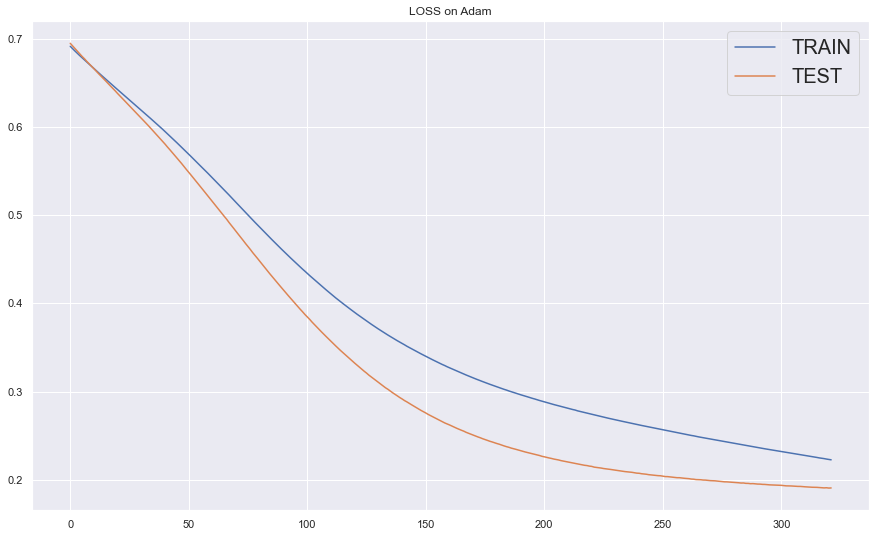

  0%|          | 0/322 [00:00<?, ?it/s]

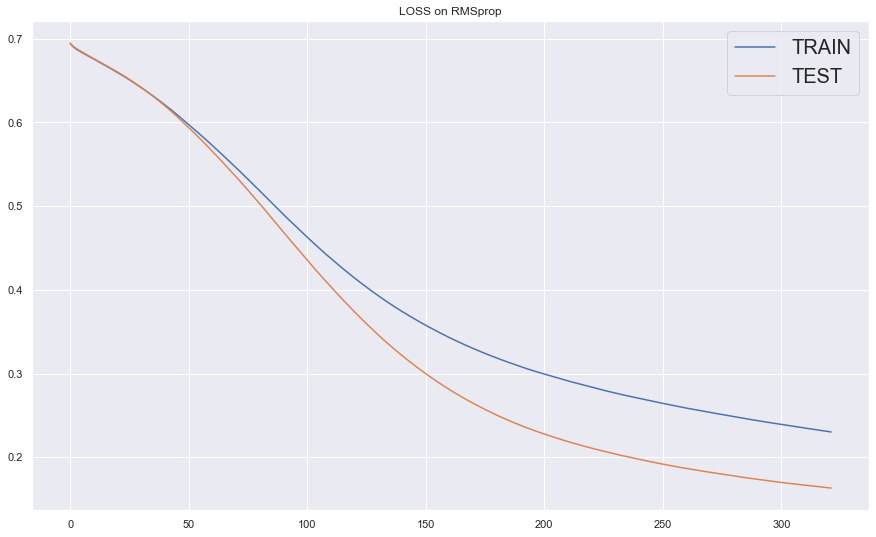

  0%|          | 0/322 [00:00<?, ?it/s]

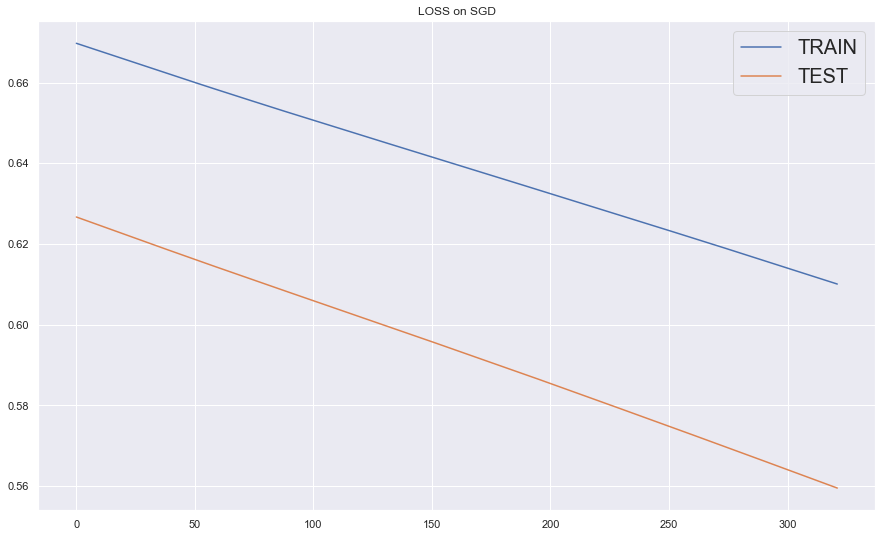

  0%|          | 0/322 [00:00<?, ?it/s]

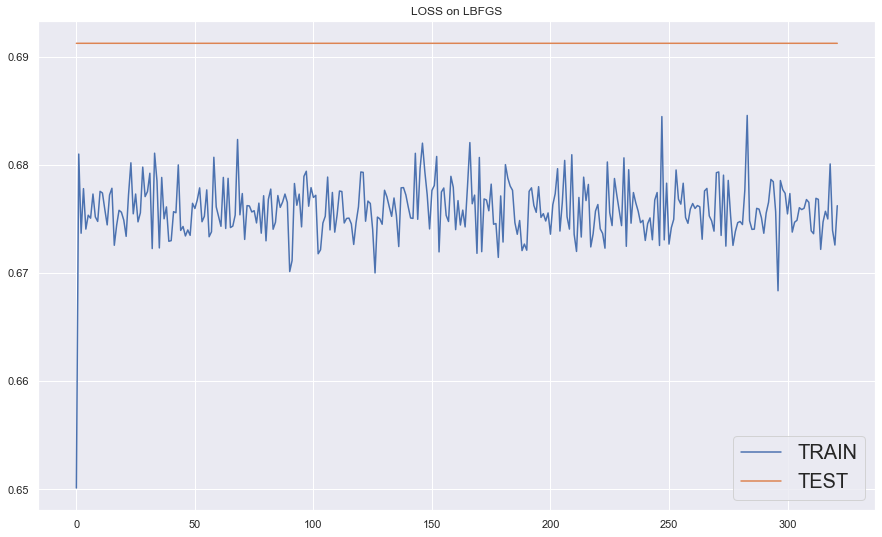

  0%|          | 0/322 [00:00<?, ?it/s]

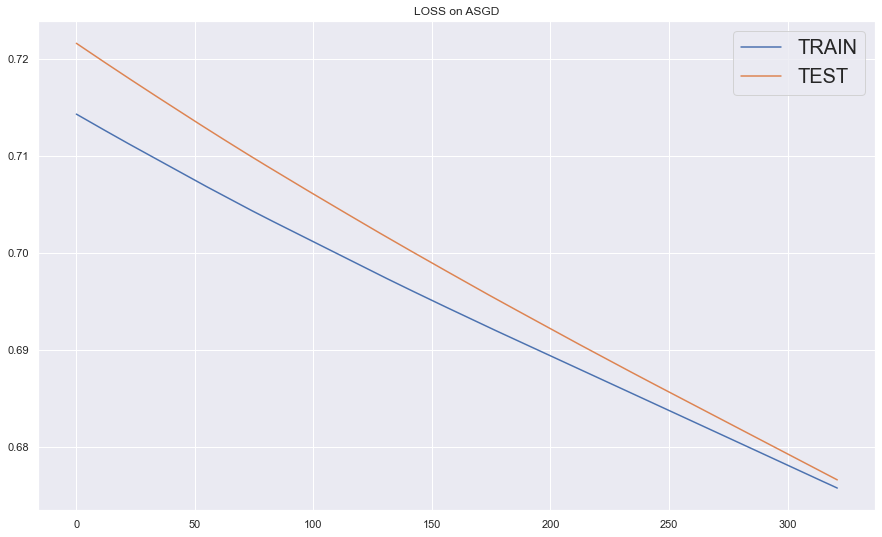

In [8]:
for name in optimizers:
    model = MLP(20, 10)
    opt = optimizers[name][0](model.parameters(), lr=0.0001)
    optimizers[name][1](name, opt, model)

ОПИШИТЕ ПОЛУЧЕНННЫЕ РЕЗУЛЬТАТЫ

Мы не занимались такими низменными вещами, как подбор параметров, размеров батчей и так далее, поэтому результаты соответствующие. Даже при перезапуске поведение графиков сильно меняется, но какой-то вывод сделать все-таки можно:
- Все, кроме LBFGS идут вниз, куда и должны
- Быстрее остальных сходятся RMSprop и Adam
- В LBFGS творится что-то страшное, видимо этот оптимизатор не переварил наше наплевательское отношение к выбору гиперпараметров
- Переобучения нет, но опять же общий вид графиков сильно меняется при повторном запуске